In [10]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
import seaborn as sns
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.linewidth"] = 0.5

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
ex_path = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep"
ex_path_kerr = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr"
ex_path_kerr8 = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr_input8"
ex_path_classical_small_kerr = './Classical_Small_kerr'

def generate_database(ex_path):
    dbGen = ResultsDatabaseGenerator()
    dbGen.initialize_from_folder(ex_path)
    data = dbGen.data
    config = data[1]['config']
    config.pop('__doc__', None)
    #config.pop('iteration', None)
    df = pd.DataFrame(columns=config.keys())
    df['num_params'] = np.nan
    df['acc'] = np.nan
    df['val_acc'] = np.nan
    df['loss'] = np.nan
    df['val_loss'] = np.nan
    for i in data.keys():
        config = data[i]['config']
        config.pop('__doc__', None)
        if config['iteration'] != -1:
            metrics = data[i]['metrics']
            metrics.pop('epoch',None)
            acc, loss, num_params, val_acc, val_loss = metrics.values()
            if acc[-1] > 0.0:
                acc = np.array(acc)
                loss = np.array(loss)
                val_acc = np.array(val_acc)
                val_loss = np.array(val_loss)
                df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]
    return df


df_orig = generate_database(ex_path)
df_kerr = generate_database(ex_path_kerr)
df_kerr8 = generate_database(ex_path_kerr8)
df_kerr8_small = generate_database(ex_path_classical_small_kerr)
df_kerr8 = pd.concat([df_kerr8, df_kerr8_small], ignore_index=True)


df_kerr.drop(df_kerr.loc[(df_kerr['network_type']=='classical') & (df_kerr['num_qumodes']==4)].index, inplace=True)
df_kerr.drop(df_kerr.loc[(df_kerr['network_type']=='classical') & (df_kerr['n_layers']==4)].index, inplace=True)
df_kerr.drop(df_kerr.loc[(df_kerr['network_type']=='classical') & (df_kerr['n_layers']==5)].index, inplace=True)

df_orig.drop_duplicates(subset=['network_type', 'num_qumodes', 'cutoff', 'n_layers', 'iteration', 'num_params'], inplace=True)
df_kerr.drop_duplicates(subset=['network_type', 'num_qumodes', 'cutoff', 'n_layers', 'iteration', 'num_params'], inplace=True)
df_kerr8.drop_duplicates(subset=['network_type', 'num_qumodes', 'cutoff', 'n_layers', 'iteration', 'num_params'], inplace=True)
df_kerr8 = df_kerr8[df_kerr8['iteration']<=10]

Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 1283. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 638. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 1277. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 775. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 705. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 531. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 724. Ignoring experiment...
Inconsistent config parameter val_accur

In [37]:
display(df_kerr8_small[df_kerr8_small['num_params']==518])

,cutoff,iteration,n_layers,network_type,num_qumodes,num_params,acc,val_acc,loss,val_loss
195,classical,9,3,classical,5,518,"[0.2514285743236542, 0.261428564786911, 0.2871...","[0.2566666603088379, 0.2433333396911621, 0.333...","[1.42197847366333, 1.3937970399856567, 1.37839...","[1.3996649980545044, 1.379576563835144, 1.3682..."
44,classical,3,3,classical,5,518,"[0.24857142567634583, 0.25999999046325684, 0.2...","[0.25, 0.2566666603088379, 0.2866666615009308,...","[1.3793712854385376, 1.3594903945922852, 1.343...","[1.3702067136764526, 1.34812593460083, 1.33359..."
192,classical,6,3,classical,5,518,"[0.24857142567634583, 0.25285714864730835, 0.3...","[0.25, 0.27666667103767395, 0.4333333373069763...","[1.3916841745376587, 1.3800642490386963, 1.369...","[1.3828319311141968, 1.3728618621826172, 1.362..."
188,classical,2,3,classical,5,518,"[0.24857142567634583, 0.2514285743236542, 0.25...","[0.25333333015441895, 0.25333333015441895, 0.2...","[1.3815816640853882, 1.3759454488754272, 1.370...","[1.3785138130187988, 1.3726582527160645, 1.366..."
191,classical,5,3,classical,5,518,"[0.24142856895923615, 0.20571428537368774, 0.2...","[0.25, 0.2266666740179062, 0.28999999165534973...","[1.3799201250076294, 1.3690073490142822, 1.358...","[1.3720759153366089, 1.3610316514968872, 1.346..."
43,classical,2,3,classical,5,518,"[0.24857142567634583, 0.3042857050895691, 0.43...","[0.24666666984558105, 0.4466666579246521, 0.44...","[1.3873146772384644, 1.3768887519836426, 1.365...","[1.378495454788208, 1.3686527013778687, 1.3567..."
189,classical,3,3,classical,5,518,"[0.24857142567634583, 0.2857142984867096, 0.28...","[0.23666666448116302, 0.2666666805744171, 0.31...","[1.3663640022277832, 1.3531535863876343, 1.339...","[1.3605152368545532, 1.346267580986023, 1.3316..."
193,classical,7,3,classical,5,518,"[0.25857141613960266, 0.2542857229709625, 0.25...","[0.2666666805744171, 0.2633333206176758, 0.270...","[1.376412034034729, 1.3654416799545288, 1.3574...","[1.36868155002594, 1.3599412441253662, 1.34996..."
46,classical,5,3,classical,5,518,"[0.2314285784959793, 0.2742857038974762, 0.268...","[0.2933333218097687, 0.2666666805744171, 0.263...","[1.391006350517273, 1.381081223487854, 1.37388...","[1.3850497007369995, 1.3769758939743042, 1.370..."
187,classical,1,3,classical,5,518,"[0.3799999952316284, 0.46142858266830444, 0.54...","[0.49000000953674316, 0.5433333516120911, 0.58...","[1.3475940227508545, 1.3192784786224365, 1.294...","[1.3225319385528564, 1.2994357347488403, 1.271..."


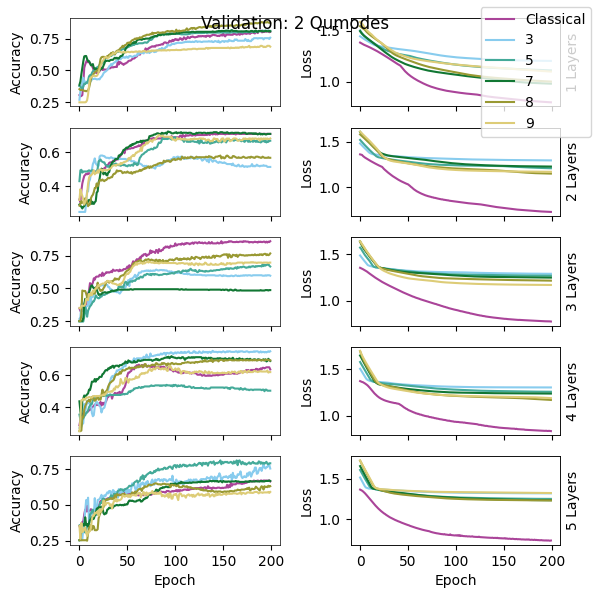

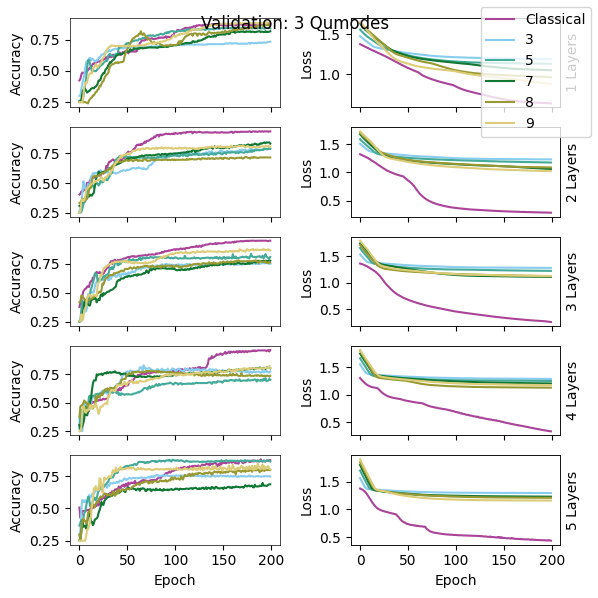

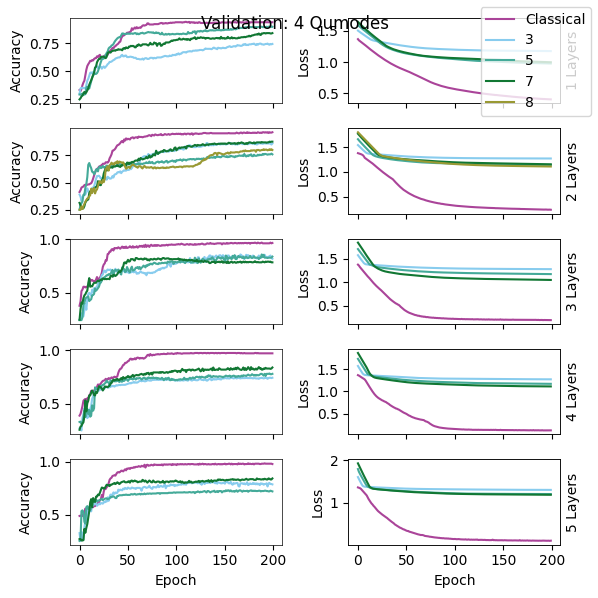

Kerr Encoding
Kerr Input 8


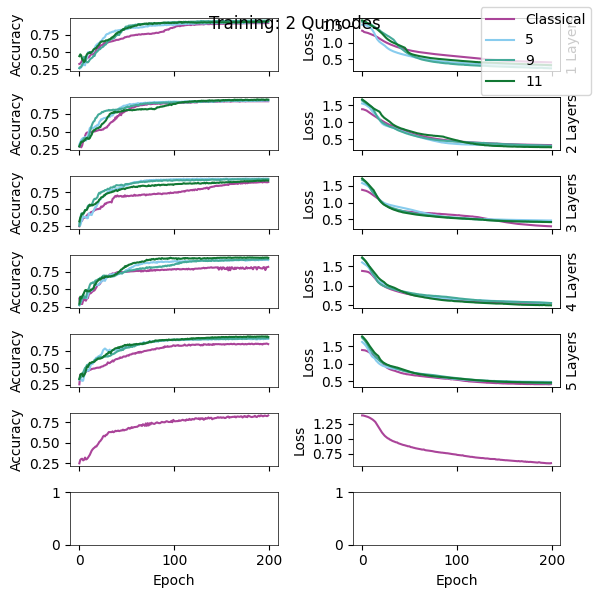

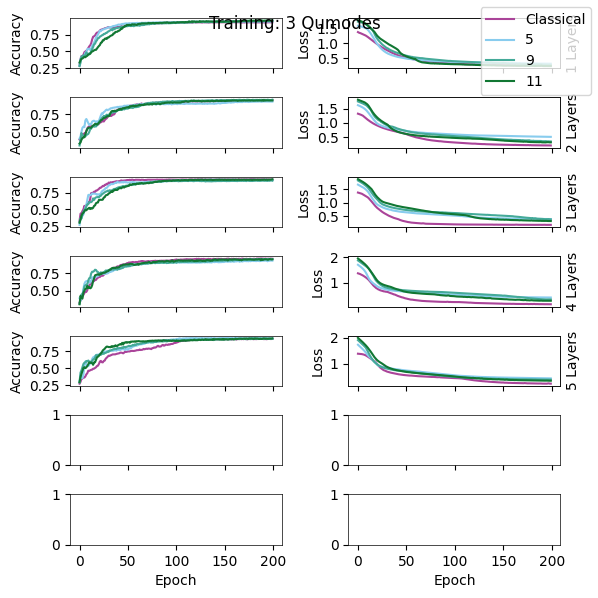

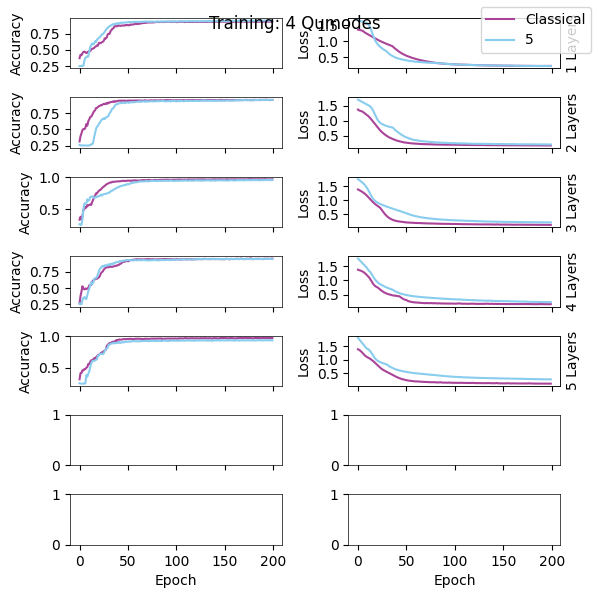

In [38]:
df_orig.loc[df_orig['network_type']=='classical', 'cutoff'] = 'classical'
df_orig.drop(df_orig[df_orig['cutoff']==1].index, inplace=True)
df_kerr8.loc[df_kerr8['network_type']=='classical', 'cutoff'] = 'classical'
def process_data(df, groups=['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff']):
    df_mean = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc': [np.mean(x['acc'].tolist(), axis=0)],
        'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
        'loss': [np.mean(x['loss'].tolist(), axis=0)],
        'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)],
        'num_exps': [len(x['acc'].tolist())],
        'raw_data':[x['acc'].tolist()]
    }))

    df_std = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc_std': [np.std(x['acc'].tolist(), axis=0)],
        'val_acc_std': [np.std(x['val_acc'].tolist(), axis=0)],
        'loss_std': [np.std(x['loss'].tolist(), axis=0)],
        'val_loss_std': [np.std(x['val_loss'].tolist(), axis=0)]
    }))
    df_max = df.groupby(groups).apply(lambda x: pd.DataFrame({
        'acc_max': [np.max(x['acc'].tolist(), axis=0)],
        'val_acc_max': [np.max(x['val_acc'].tolist(), axis=0)],
        'loss_min': [np.min(x['loss'].tolist(), axis=0)],
        'val_loss_min': [np.min(x['val_loss'].tolist(), axis=0)]
    }))
    df_out = pd.concat([df_mean, df_std, df_max], axis=1)
    df_out.reset_index(inplace=True)
    df_out.drop(columns=f'level_{len(groups)}', inplace=True)
    df_out.sort_values(['network_type', 'num_qumodes', 'n_layers'],inplace=True)
    return df_out
df_o = process_data(df_orig)
df_k = process_data(df_kerr)
df_k8 = process_data(df_kerr8)

def plot_training_cutoff_sweep(df, fname='cutoff_sweep', dataset='training'):

    for n in df.loc[df['network_type']=='quantum', 'num_qumodes'].unique():
        df_n = df[df['num_qumodes']==n]
        fig, axs = plt.subplots(ncols=2, nrows=len(df['n_layers'].unique()), figsize=(6,6), sharex=True)
        color_dict = dict(zip(df[df['num_qumodes']==n]['cutoff'].unique(), colors))
        color_dict['classical'] = colors[-1]
        for i in df_n.loc[df_n['network_type']=='quantum', 'n_layers'].unique():
            ax2  = axs[i-1,1].twinx()
            ax2.set_yticks([])
            ax2.set_yticklabels([])
            ax2.set_ylabel(f'{i} Layers')
        prefix = 'val_' if dataset=='validation' else '' 
        for i, row in df_n.iterrows():
            idx_row = row['n_layers'] - 1
            epochs = [i for i in range(len(row[prefix+'acc_max']))]
            axs[idx_row, 0].plot(epochs, row[prefix+'acc_max'], color=color_dict[row['cutoff']])
            axs[idx_row, 1].plot(epochs, row[prefix+'loss_min'], color=color_dict[row['cutoff']])
            
            axs[-1,0].set_xlabel('Epoch')
            axs[-1,1].set_xlabel('Epoch')
            axs[idx_row,0].set_ylabel('Accuracy')
            axs[idx_row,1].set_ylabel('Loss')


        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        fig.legend()
        fig.tight_layout()
        fig.suptitle(f'{dataset.capitalize()}: {n} Qumodes')
        plt.savefig(f'./cutoff_sweep_plots/{fname}_{dataset.capitalize()}_{n}qumodes.png', dpi=300)
        plt.show()

plot_training_cutoff_sweep(df_o, 'cutoff_sweep', dataset='validation')
print('Kerr Encoding')
#plot_training_cutoff_sweep(df_k, 'cutoff_sweep_kerr')
# plot_training_cutoff_sweep(df_k, 'cutoff_sweep_kerr', dataset='validation')

print('Kerr Input 8')
plot_training_cutoff_sweep(df_k8, 'cutoff_sweep_kerr8')



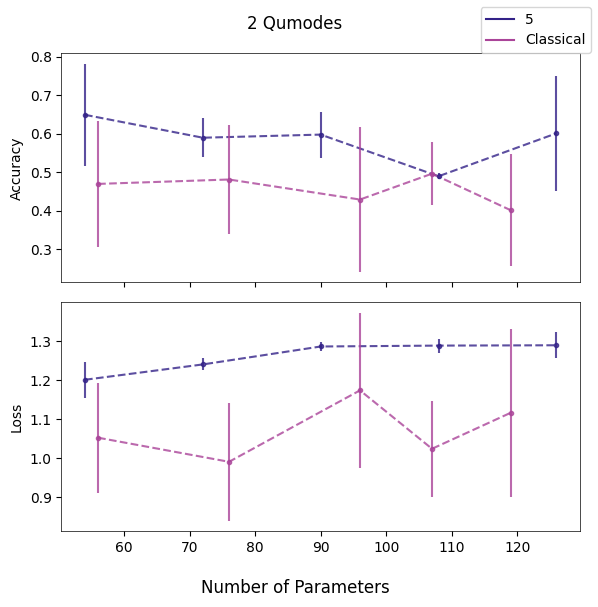

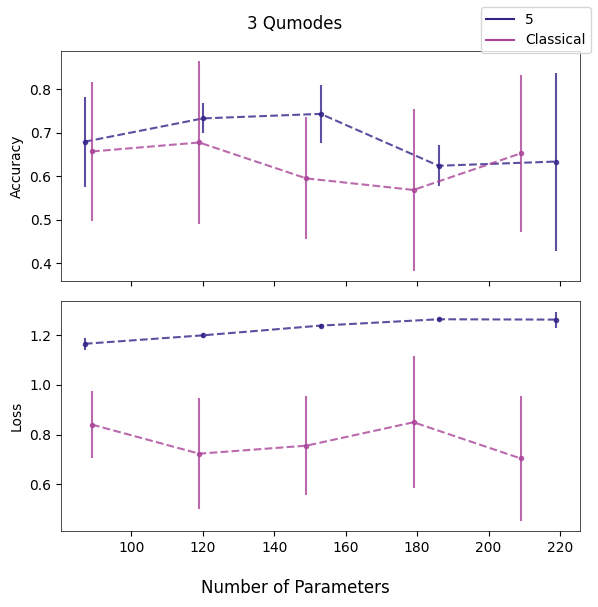

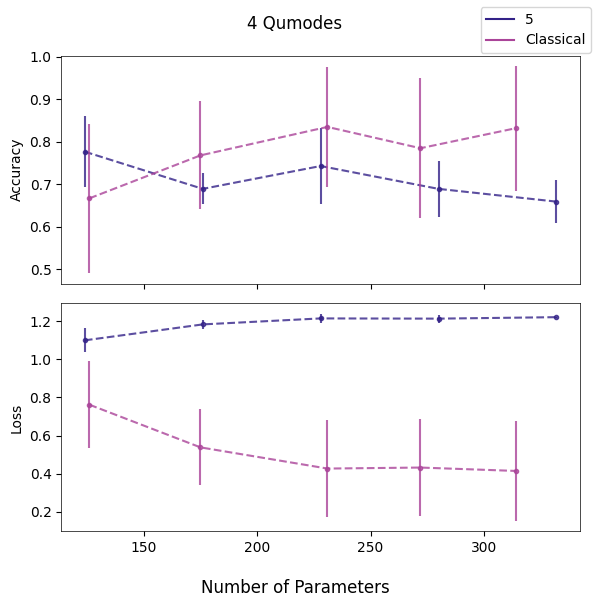

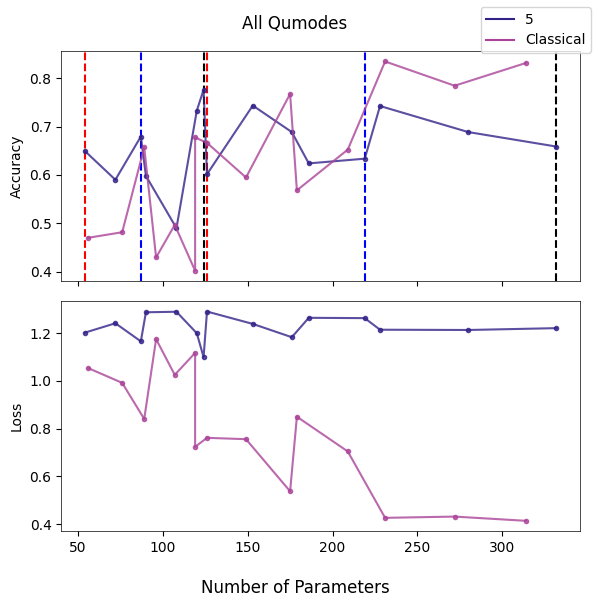

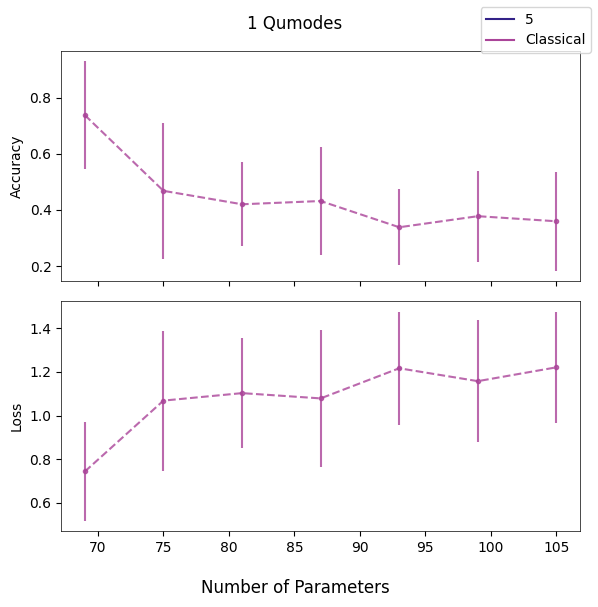

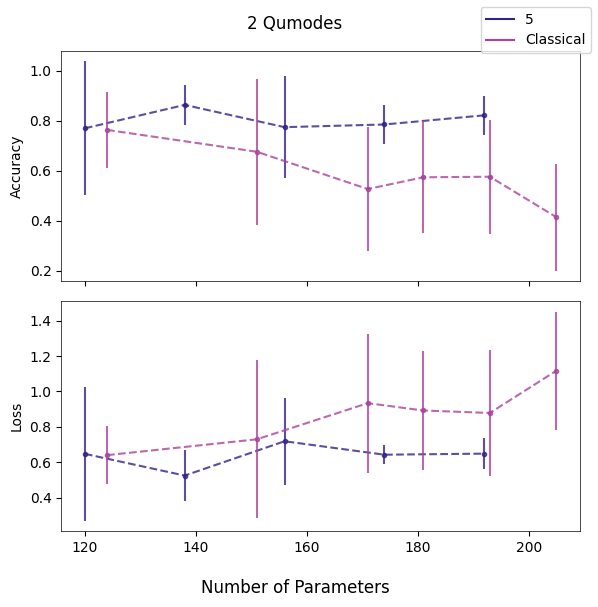

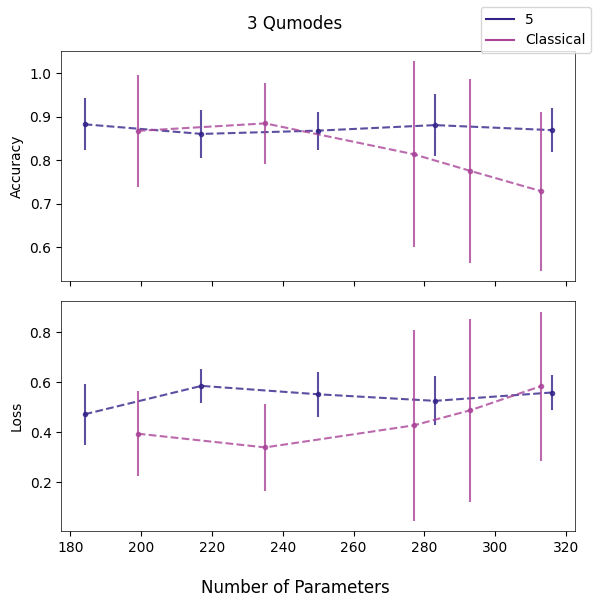

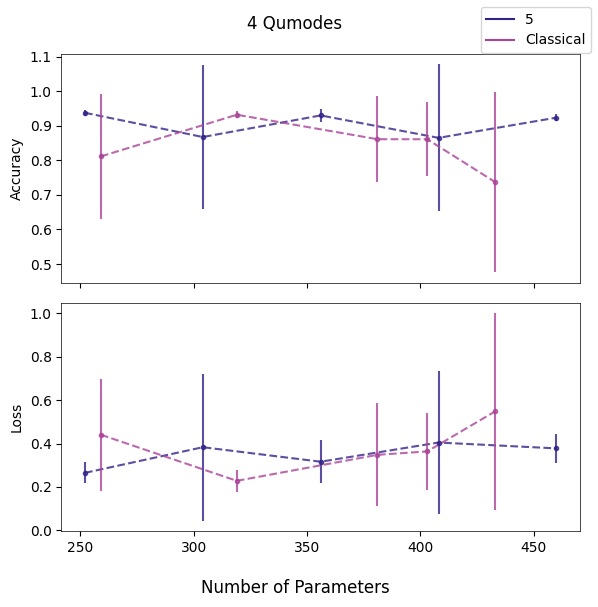

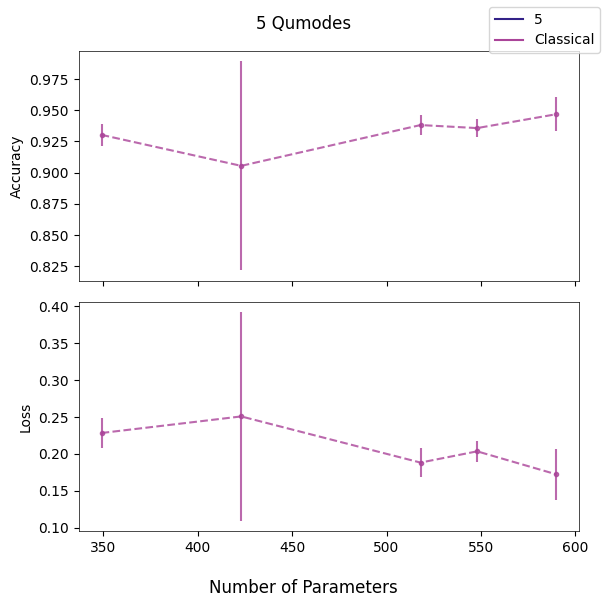

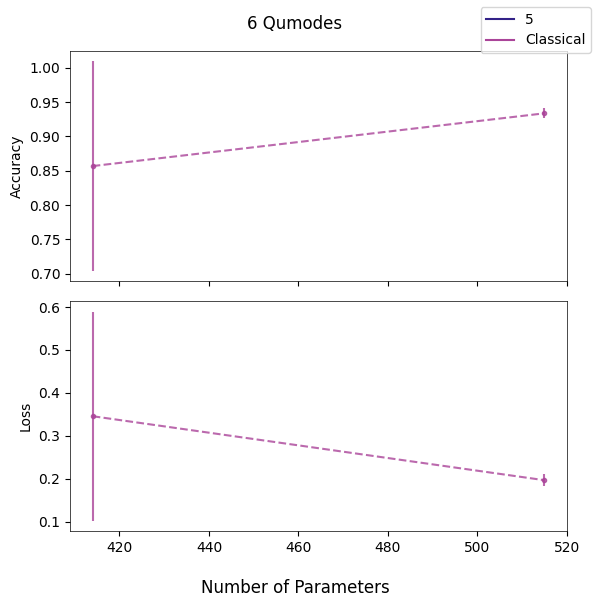

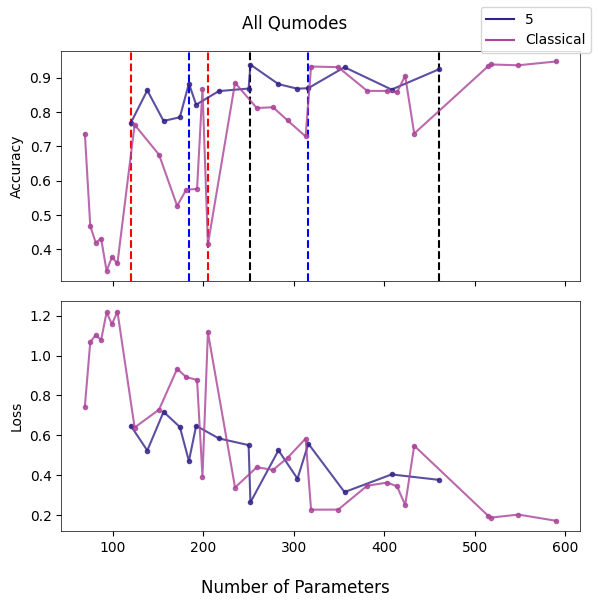

In [39]:

def generate_averaged_database(df):
    df_mean = copy.deepcopy(df)
    df_mean['acc'] = df_mean['acc'].apply(lambda x: x[-1])
    df_mean['acc_max'] = df_mean['acc_max'].apply(lambda x: x[-1])
    df_mean['acc_std'] = df_mean['acc_std'].apply(lambda x: x[-1])
    df_mean['acc_max_std'] = df_mean['acc_std'] 
    df_mean['val_acc'] = df_mean['val_acc'].apply(lambda x: x[-1])
    df_mean['val_acc_std'] = df_mean['val_acc_std'].apply(lambda x: x[-1])
    df_mean['loss'] = df_mean['loss'].apply(lambda x: x[-1])
    df_mean['loss_std'] = df_mean['loss_std'].apply(lambda x: x[-1])
    df_mean['val_loss'] = df_mean['val_loss'].apply(lambda x: x[-1])
    df_mean['val_loss_min'] = df_mean['val_loss_min'].apply(lambda x: x[-1])
    df_mean['val_loss_std'] = df_mean['val_loss_std'].apply(lambda x: x[-1])
    df_mean['acc_ratio'] = df_mean['acc']/df_mean['num_params']
    df_mean['acc_ratio_std'] = df_mean['acc_std']/df_mean['num_params']
    df_mean['val_acc_ratio'] = df_mean['val_acc']/df_mean['num_params']
    df_mean['val_acc_ratio_std'] = df_mean['val_acc_std']/df_mean['num_params']
    df_mean['loss_ratio'] = df_mean['loss']/df_mean['num_params']
    df_mean['loss_ratio_std'] = df_mean['loss_std']/df_mean['num_params']
    df_mean['val_loss_ratio'] = df_mean['val_loss']/df_mean['num_params']
    df_mean['val_loss_ratio_std'] = df_mean['val_loss_std']/df_mean['num_params']
    df_mean.sort_values('num_params')
    return df_mean

def plot_acc_per_param(df, fname='AccPerParam', cutoffs=[3,7,9,'classical']):
    color_dict = dict(zip(cutoffs, colors))
    color_dict['classical'] = colors[-1]
    metrics = ['acc', 'loss']
    axs_labels_dict = dict(zip(metrics, ['Accuracy', 'Loss', 'Accuracy', 'Loss']))
    for n in df['num_qumodes'].unique():
        fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,6), sharex=True)
        axs_dict = dict(zip(metrics, axs.flatten()))
        for cutoff in cutoffs:
            row = df.loc[(df['num_qumodes']==n) & (df['cutoff']==cutoff)]
            for metric in metrics:
                axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                axs_dict[metric].plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)


        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        # ax2  = axs[0].twinx()
        # ax2.set_yticks([])
        # ax2.set_yticklabels([])
        # ax2.set_ylabel(f'Training') 
    
        # ax2  = axs[1].twinx()
        # ax2.set_yticks([])
        # ax2.set_yticklabels([])
        # ax2.set_ylabel(f'Testing')   

        fig.legend()
        fig.supxlabel('Number of Parameters')
        fig.suptitle(f'{n} Qumodes')

        for key, val in axs_labels_dict.items():
            axs_dict[key].set_ylabel(val)
        fig.tight_layout()
        plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_{n}qumodes.png', dpi=300)
        plt.show()


    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,6), sharex=True)
    axs_dict = dict(zip(metrics, axs.flatten()))
    axs[0].axvline(x=df[df['num_qumodes']==4]['num_params'].min(), color='k', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==4]['num_params'].max(), color='k', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==3]['num_params'].min(), color='b', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==3]['num_params'].max(), color='b', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==2]['num_params'].min(), color='r', linestyle='--')
    axs[0].axvline(x=df[df['num_qumodes']==2]['num_params'].max(), color='r', linestyle='--')
    for cutoff in cutoffs:
            row = copy.deepcopy(df[(df['cutoff']==cutoff)])
            row.sort_values('num_params', inplace=True)
            for metric in metrics:
                #axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                axs_dict[metric].plot(row['num_params'].values, row[metric].values, '-', marker='.', color=color_dict[cutoff], alpha=0.8)

    for key,val in color_dict.items():
        plt.plot([], [], color=val, label=f'{key}'.capitalize())

    # ax2  = axs[1].twinx()
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    # ax2.set_ylabel(f'Training') 

    # ax2  = axs[1].twinx()
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    # ax2.set_ylabel(f'Testing')   

    fig.legend()
    fig.supxlabel('Number of Parameters')
    fig.suptitle(f'All Qumodes')
    for key, val in axs_labels_dict.items():
        axs_dict[key].set_ylabel(val)
    fig.tight_layout()
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_allqumodes.png', dpi=300)
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_allqumodes.svg')
    plt.show()
    
    
    # fig, axs = plt.subplots(figsize=(6,6), sharex=True)
    # metric = 'val_acc'
    # for cutoff in cutoffs:
    #     row = copy.deepcopy(df[(df['cutoff']==cutoff)])
    #     row.sort_values('num_params', inplace=True)
    #     #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
    #     axs.plot(row['num_params'].values, row[metric].values, '-', color=color_dict[cutoff], alpha=0.8)

    # for key in cutoffs:
    #     plt.plot([], [], color=color_dict[key], label=f'{key}'.capitalize()) 

    # fig.legend()
    # fig.supxlabel('Number of Parameters')
    # axs.set_ylabel('Validation Accuracy')
    # fig.tight_layout()
    # plt.savefig(f'cutoff_sweep_plots/{fname}_AccLarg_allqumodes.png', dpi=300)
    # plt.show()


    
    

df_o_mean = generate_averaged_database(df_o)
df_k_mean = generate_averaged_database(df_k)
df_k8_mean = generate_averaged_database(df_k8)
plot_acc_per_param(df_o_mean, 'cutoff_sweep', cutoffs=[5,'classical'])
#plot_acc_per_param(df_k_mean, 'cutoff_sweep_kerr', cutoffs=[5,10,'classical'])
plot_acc_per_param(df_k8_mean, 'cutoff_sweep_kerr8', cutoffs=[5,'classical'])


# def plot_comparison(metric, ylabel='Validation Accuracy'):
#     fig, axs = plt.subplots(figsize=(6,6), sharex=True)
#     color_dict = dict(zip([5,7,10,'classical'], colors))
#     for cutoff in [7,'classical']:
#         row = copy.deepcopy(df_o_mean[(df_o_mean['cutoff']==cutoff)])
#         row.sort_values('num_params', inplace=True)
#         #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
#         axs.plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)
#         #axs.fill_between(row['num_params'].values, row[metric]-row[f'{metric}_std'], row[metric]+row[f'{metric}_std'], color=color_dict[cutoff], alpha=0.1)
#     for cutoff in [10,'classical']:
#         row = copy.deepcopy(df_k_mean[(df_k_mean['cutoff']==cutoff)])
#         row.sort_values('num_params', inplace=True)
#         #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
#         axs.plot(row['num_params'].values, row[metric].values, '--', color=color_dict[cutoff], alpha=0.8)
#         #axs.fill_between(row['num_params'].values, row[metric]-row[f'{metric}_std'], row[metric]+row[f'{metric}_std'], color=color_dict[cutoff], alpha=0.1)

#     def legend(label, color, linestyle='-', marker=''):
#         plt.plot([],[], color=color, ls=linestyle, marker=marker, label=label.capitalize())
#         return

# plot_comparison('val_acc', 'Validation Accuracy')
# plot_comparison('loss', 'Loss')


# Accuracy Violin Plots

/tmp/ipykernel_7360/1940581968.py:52: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  frame1.set_xticks([])


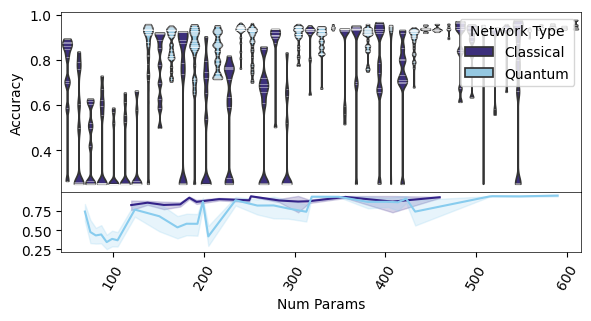

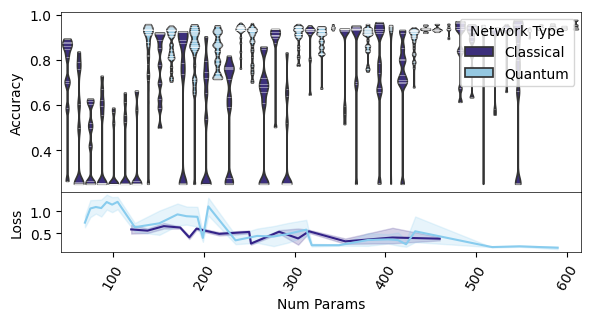

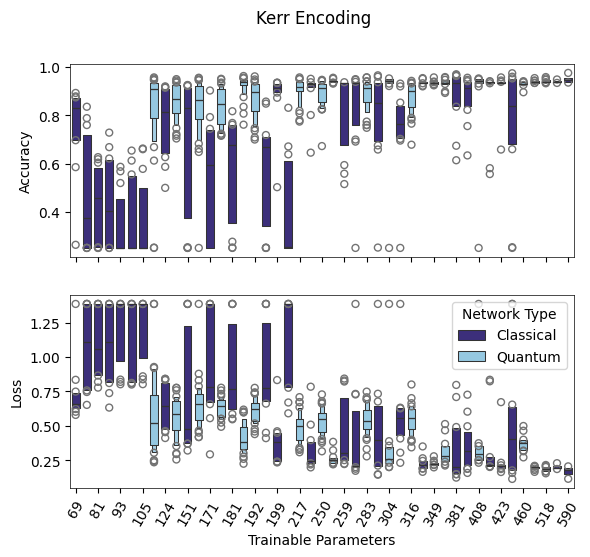

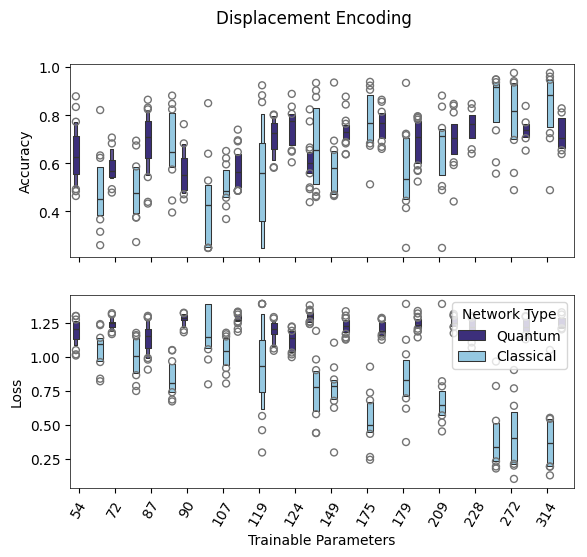

In [43]:
def pd_last_epoch(df):
    df_out = copy.deepcopy(df)
    df_out['acc'] = df_out['acc'].apply(lambda x: max(x))
    df_out['val_acc'] = df_out['val_acc'].apply(lambda x: max(x))
    df_out['loss'] = df_out['loss'].apply(lambda x: min(x))
    df_out['val_loss'] = df_out['val_loss'].apply(lambda x: min(x))
    return df_out

encodings = {'displacement': df_orig, 'kerr': df_kerr, 'kerr8': df_kerr8}
df_full = pd.concat(encodings, names=['encoding'])
df_full = df_full.reset_index(level=0)
df_f_stat = pd_last_epoch(df_full)
pd.to_pickle(df_full, 'df_full.pkl')
df_f = process_data(df_full, groups=['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff', 'encoding'])
df_f_mean = generate_averaged_database(df_f)
df_o_stat = pd_last_epoch(df_orig)
df_k_stat = pd_last_epoch(df_kerr)
df_k8_stat = pd_last_epoch(df_kerr8)
# df_o_stat = df_o_stat[df_o_stat['acc'] > 0.3]
# df_k_stat = df_k_stat[df_k_stat['acc'] > 0.3]
# df_k8_stat = df_k8_stat[df_k8_stat['acc'] > 0.3]
df_f_stat_quantum = copy.deepcopy(df_f_stat[df_f_stat['network_type'] == 'quantum'])
df_f_stat_quantum['cutoff'] = df_f_stat_quantum['cutoff'].apply(pd.to_numeric)
df_o_stat_quantum = copy.deepcopy(df_o_stat[df_o_stat['network_type'] == 'quantum'])
df_o_stat_quantum['cutoff'] = df_o_stat_quantum['cutoff'].apply(pd.to_numeric)
df_k_stat_quantum = copy.deepcopy(df_k_stat[df_k_stat['network_type'] == 'quantum'])
df_k_stat_quantum['cutoff'] = df_k_stat_quantum['cutoff'].apply(pd.to_numeric)
df_k8_stat_quantum = copy.deepcopy(df_k8_stat[df_k8_stat['network_type'] == 'quantum'])
df_k8_stat_quantum = df_k8_stat_quantum['cutoff'].apply(pd.to_numeric)


#sns.boxenplot(df_k_mean, x='num_qumodes', y='acc', hue='network_type', k_depth='trustworthy')
#plt.show()
# plt.show()
# sns.violinplot(df_k_mean, x='num_qumodes', y='acc', hue='network_type', split=False, cut=True, bw_method=0.1)
# plt.show()
# sns.violinplot(df_o_mean, x='num_qumodes', y='acc', hue='network_type', split=False, cut=True, bw_method=0.1)
# plt.show()
# sns.violinplot(df_f_mean[df_f_mean['network_type']=='quantum'], x='num_qumodes', y='acc', hue='encoding', split=False, cut=True, bw_method=0.1)
# plt.show()
# sns.violinplot(df_k8_mean, x='num_qumodes', y='acc', hue='network_type', split=False, cut=True, bw_method=0.1)
# plt.show()

df_k8_stat['network_type'] = df_k8_stat.network_type.str.capitalize()
df_k8_stat.columns = df_k8_stat.columns.str.title().str.replace('_', " ")

fig1 = plt.figure(figsize=(6.5, 3))
frame1=fig1.add_axes((.1,.3,.8,.6))
ax1 = sns.violinplot(df_k8_stat, x='Num Params', y='Acc', hue='Network Type', 
               width=0.8, bw_method=0.1, inner='stick', split=False, cut=0, 
               density_norm='count', inner_kws={'color': 'white', 'alpha':0.5})
frame1.set_xticks([])
frame1.set_xlabel('')

frame2 = fig1.add_axes((.1,.1,.8,.2))

ax2 = sns.lineplot(df_k8_stat, x='Num Params', y='Acc', hue=df_k8_stat['Network Type'], hue_order=['Quantum', 'Classical'],legend=None)

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('')

plt.xticks(rotation=60)
plt.show()

fig1 = plt.figure(figsize=(6.5, 3))
frame1=fig1.add_axes((.1,.3,.8,.6))
ax1 = sns.violinplot(df_k8_stat, x='Num Params', y='Acc', hue='Network Type', 
               width=0.8, bw_method=0.1, inner='stick', split=False, cut=0, 
               density_norm='count', inner_kws={'color': 'white', 'alpha':0.5})
frame1.set_xticklabels([])
frame1.set_xlabel('')

frame2 = fig1.add_axes((.1,.1,.8,.2))

ax2 = sns.lineplot(df_k8_stat, x='Num Params', y='Loss', hue=df_k8_stat['Network Type'], hue_order=['Quantum', 'Classical'],legend=None)

ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

plt.xticks(rotation=60)
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6.5, 5.5), sharex=True)
ax1 = sns.boxenplot(df_k8_stat.sort_values('Network Type'), ax=ax[0], x='Num Params', y='Acc', 
                    hue='Network Type', width_method='exponential', k_depth='trustworthy', 
                    width=0.7, legend=None)
plt.xticks(rotation=90)
ax2 = sns.boxenplot(df_k8_stat.sort_values('Network Type'), ax=ax[1], 
              x='Num Params', y='Loss', hue='Network Type', 
              width_method='exponential', k_depth='trustworthy',
              width=0.7, legend=True)

sns.move_legend(ax2, 'upper right')
plt.xticks(rotation=60)
ax1.set(ylabel='Accuracy')
ax2.set(xlabel='Trainable Parameters', ylabel='Loss')
n = 2
[l.set_visible(False) for (i,l) in enumerate(ax2.xaxis.get_major_ticks()) if i % n != 0]
[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_major_ticks()) if i % n != 0]
fig.suptitle('Kerr Encoding')
plt.savefig('kerr_encoding_boxenplot.svg')
plt.show()

df_o_stat['network_type'] = df_o_stat.network_type.str.capitalize()
df_o_stat.columns = df_k8_stat.columns.str.title().str.replace('_', " ")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6.5, 5.5), sharex=True)
ax1 = sns.boxenplot(df_o_stat.sort_values('Network Type'), ax=ax[0], x='Num Params', y='Acc', 
                    hue='Network Type', width_method='exponential', k_depth='trustworthy', 
                    width=0.7, legend=None)
plt.xticks(rotation=90)
ax2 = sns.boxenplot(df_o_stat.sort_values('Network Type'), ax=ax[1], 
              x='Num Params', y='Loss', hue='Network Type', 
              width_method='exponential', k_depth='trustworthy',
              width=0.7, legend=True)

sns.move_legend(ax2, 'upper right')
plt.xticks(rotation=60)
ax1.set(ylabel='Accuracy')
ax2.set(xlabel='Trainable Parameters', ylabel='Loss')
[l.set_visible(False) for (i,l) in enumerate(ax2.xaxis.get_major_ticks()) if i % n != 0]
[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_major_ticks()) if i % n != 0]
fig.suptitle('Displacement Encoding')
plt.savefig('displacement_encoding_boxenplot.svg')
plt.show()



In [64]:
display(df_k8_mean[(df_k8_mean['network_type']=='classical') & (df_k8_mean['num_params']==69)])
display(df_k8_mean.sort_values('num_params').head(20))

,network_type,n_layers,num_qumodes,num_params,cutoff,acc,val_acc,loss,val_loss,num_exps,...,val_loss_min,acc_max_std,acc_ratio,acc_ratio_std,val_acc_ratio,val_acc_ratio_std,loss_ratio,loss_ratio_std,val_loss_ratio,val_loss_ratio_std
0,classical,1,1,69,classical,0.737286,0.737667,0.743714,0.718143,10,...,0.553553,0.191344,0.010685,0.002773,0.010691,0.002713,0.010778,0.003273,0.010408,0.003399


,network_type,n_layers,num_qumodes,num_params,cutoff,acc,val_acc,loss,val_loss,num_exps,...,val_loss_min,acc_max_std,acc_ratio,acc_ratio_std,val_acc_ratio,val_acc_ratio_std,loss_ratio,loss_ratio_std,val_loss_ratio,val_loss_ratio_std
0,classical,1,1,69,classical,0.737286,0.737667,0.743714,0.718143,10,...,0.553553,0.191344,0.010685,0.002773,0.010691,0.002713,0.010778,0.003273,0.010408,0.003399
6,classical,2,1,75,classical,0.467857,0.471000,1.068222,1.062640,10,...,0.628828,0.242161,0.006238,0.003229,0.006280,0.003181,0.014243,0.004276,0.014169,0.004353
12,classical,3,1,81,classical,0.420000,0.423667,1.102520,1.097555,10,...,0.764168,0.148788,0.005185,0.001837,0.005230,0.001920,0.013611,0.003095,0.013550,0.003216
17,classical,4,1,87,classical,0.431571,0.436333,1.078383,1.073330,10,...,0.620637,0.191540,0.004961,0.002202,0.005015,0.002216,0.012395,0.003595,0.012337,0.003660
22,classical,5,1,93,classical,0.338143,0.345333,1.216308,1.212280,10,...,0.788904,0.135564,0.003636,0.001458,0.003713,0.001559,0.013079,0.002793,0.013035,0.002859
27,classical,6,1,99,classical,0.377571,0.383000,1.157323,1.152252,10,...,0.789327,0.162334,0.003814,0.001640,0.003869,0.001665,0.011690,0.002834,0.011639,0.002896
29,classical,7,1,105,classical,0.359429,0.363000,1.220610,1.219271,10,...,0.797055,0.176183,0.003423,0.001678,0.003457,0.001637,0.011625,0.002414,0.011612,0.002432
31,quantum,1,2,120,9,0.837286,0.849333,0.508150,0.487873,10,...,0.204844,0.156387,0.006977,0.001303,0.007078,0.001279,0.004235,0.001999,0.004066,0.002034
30,quantum,1,2,120,5,0.769286,0.773667,0.647062,0.631916,10,...,0.296688,0.266830,0.006411,0.002224,0.006447,0.002201,0.005392,0.003154,0.005266,0.003217
32,quantum,1,2,120,11,0.818000,0.819333,0.612154,0.603794,10,...,0.311098,0.128321,0.006817,0.001069,0.006828,0.001046,0.005101,0.001852,0.005032,0.001886


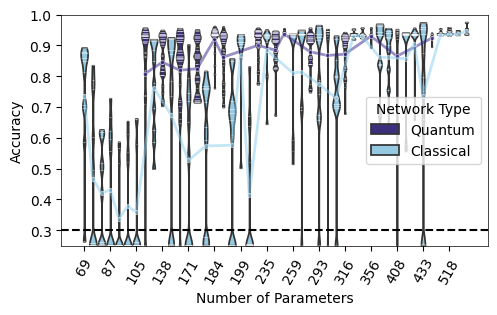

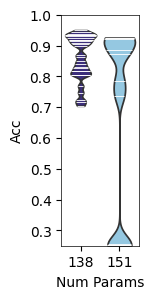

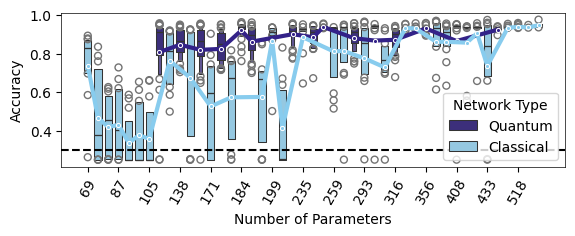

In [69]:
n = 3
fig1 = plt.figure(figsize=(5.5,3))
ax1 = sns.violinplot(df_k8_stat, x='Num Params', y='Acc', hue='Network Type', 
               hue_order=['Quantum', 'Classical'], width=0.8, bw_method=0.1, inner='stick', split=False, cut=0, 
               density_norm='count', inner_kws={'color': 'white', 'alpha':0.5})

df_k8_m = copy.deepcopy(df_k8_mean)
df_k8_m.replace({'cutoff': {'classical': -1}}, inplace=True)
df_k8_m['cutoff'] = df_k8_m['cutoff'].apply(pd.to_numeric)
df_k8_m.drop(columns=['raw_data'], inplace=True)
columns = list(df_k8_m.columns)
columns.remove('cutoff')
df_k8_m = df_k8_m.groupby(['num_params', 'network_type']).mean()
df_k8_m.reset_index(inplace=True)
df_k8_m = df_k8_m.sort_values('num_params')
 
#plt.plot(df_k8_m[df_k8_m['network_type']=='classical']['acc'], '--', color='k', alpha=0.8)
sns.lineplot(df_k8_m, x=df_k8_m.index, y='acc', 
             #style='network_type', 
             hue='network_type',
             linewidth=2,
             marker='.',
             hue_order=['quantum', 'classical'],
             style_order=['quantum', 'classical'], 
             alpha=0.5,
             legend=None)
plt.axhline(y=0.3, color='k', linestyle='--')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Parameters')
plt.ylim(0.25, 1.0)

[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_major_ticks()) if i % n != 0]
plt.xticks(rotation=60)
plt.savefig('kerr_encoding_violinplot.svg')
plt.show()


fig= plt.figure(figsize=(1,3))
ax1 = sns.violinplot(df_k8_stat[(df_k8_stat['Num Params'] == 138) | (df_k8_stat['Num Params']== 151)], x='Num Params', y='Acc', hue='Network Type', legend=None, 
               hue_order=['Quantum', 'Classical'], width=0.8, bw_method=0.1, inner='stick', split=False, cut=0, 
               density_norm='count', inner_kws={'color': 'white', 'alpha':1.0})
plt.ylim(0.25,1.0)


plt.show()

fig1 = plt.figure(figsize=(6.5, 2))
ax1 = sns.boxenplot(df_k8_stat, x='Num Params', y='Acc', 
                    hue='Network Type', width_method='exponential', k_depth='trustworthy', 
                    width=0.7, hue_order=['Quantum', 'Classical'])
df_k8_m = copy.deepcopy(df_k8_mean)
df_k8_m.replace({'cutoff': {'classical': -1}}, inplace=True)
df_k8_m['cutoff'] = df_k8_m['cutoff'].apply(pd.to_numeric)
df_k8_m.drop(columns=['raw_data'], inplace=True)
columns = list(df_k8_m.columns)
columns.remove('cutoff')
df_k8_m = df_k8_m.groupby(['num_params', 'network_type']).mean()
df_k8_m.reset_index(inplace=True)
df_k8_m = df_k8_m.sort_values('num_params')
 
#plt.plot(df_k8_m[df_k8_m['network_type']=='classical']['acc'], '--', color='k', alpha=0.8)
sns.lineplot(df_k8_m, x=df_k8_m.index, y='acc', 
             #style='network_type', 
             hue='network_type',
             linewidth=3,
             marker='.',
             hue_order=['quantum', 'classical'],
             style_order=['quantum', 'classical'], legend=None)
plt.axhline(y=0.3, color='k', linestyle='--')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Parameters')

[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_major_ticks()) if i % n != 0]

plt.xticks(rotation=60)
plt.savefig('kerr_encoding_boxenplot.svg')
plt.show()

In [ ]:
def plot_param_sweep(df, param='cutoff', fname='cutoff_sweep'):    
    df_cutoff = df[df['network_type']=='quantum'].groupby([param, 'num_qumodes']).apply(np.mean)
    df_cutoff[param] = df_cutoff[param].apply(int)
    df_classical = df[df['network_type']=='classical'].groupby([param, 'num_qumodes']).apply(np.mean)

    color_dict = dict(zip(df['num_qumodes'].unique(), colors))
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)
    axs[0,0].set_ylabel('Accuracy')
    axs[1,0].set_ylabel('Accuracy')
    axs[0,1].set_ylabel('Loss')
    axs[1,1].set_ylabel('Loss')

    axs[1,0].set_xlabel(param.capitalize())
    axs[1,1].set_xlabel(param.capitalize())

    axs[0,0].set_xticks(df_cutoff[param].unique(), df_cutoff[param].unique())
    axs_dict = dict(zip(['acc', 'loss', 'val_acc', 'val_loss'], axs.flatten()))
    for i, row in df_cutoff.iterrows():
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            axs_dict[metric].errorbar(row[param], row[metric], yerr=row[f'{metric}_std'], fmt='o', color=color_dict[row['num_qumodes']], alpha=0.8)

    if param == 'n_layers':
        alpha = lambda x: 0.8*(x/df_classical[param].unique()[-1])
        for i, row in df_classical.iterrows():
            for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
                axs_dict[metric].hlines([row[metric], row[metric]], df_cutoff[param].unique()[0], df_cutoff[param].unique()[-1], ls='--', color=color_dict[row['num_qumodes']], alpha=alpha(row[param]))
    else:
         for i, row in df_classical.iterrows():
            for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
                axs_dict[metric].hlines([row[metric], row[metric]], df_cutoff[param].unique()[0], df_cutoff[param].unique()[-1], ls='--', color=color_dict[row['num_qumodes']], alpha=0.8)


    for key,val in color_dict.items():
        plt.plot([], [], marker='o', lw=0 , color=val, label=f'{key} Qumodes')

    ax2  = axs[0,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Training') 

    ax2  = axs[1,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Testing')   
    fig.suptitle(f'Param Sweep: {param.capitalize()}')

    fig.legend()
    fig.tight_layout()

plot_param_sweep(df_o_mean, param='cutoff', fname='cutoff_sweep')
plot_param_sweep(df_k_mean, param='cutoff', fname='cutoff_sweep_kerr')
plot_param_sweep(df_o_mean, param='n_layers', fname='n_layers_sweep')
plot_param_sweep(df_k_mean, param='n_layers', fname='n_layers_sweep_kerr')
plot_param_sweep(df_k8_mean, param='cutoff', fname='cutoff_sweep_kerr8')
plot_param_sweep(df_k8_mean, param='n_layers', fname='n_layers_sweep_kerr8')

# Generate timing plots

In [ ]:
from common_packages.calc_time import calc_time, generate_time_database, calc_time_per_epoch, find_max_time
import seaborn as sns
def generate_time_df(ex_path):
    time_data = generate_time_database(ex_path) 
    df_time = pd.DataFrame(columns=time_data[1]['config'].keys())
    df_time['time'] = np.nan
    df_time.pop('__doc__')
    for exp, val in time_data.items():
        config = val['config']
        config.pop('__doc__', None)
        if config['iteration'] != -1:
            time = val['time']
            df_time.loc[exp] = [*config.values(), time] 
    df_time.pop('iteration')
    df_time.loc[df_time['network_type']=='classical', 'cutoff'] = 0
    df_time['time'] = df_time['time'] / np.timedelta64(1,'h')
    df_time_mean = df_time.groupby(['network_type', 'n_layers', 'num_qumodes', 'cutoff']).mean()
    df_time_mean.reset_index(inplace=True)
    display(df_time.head())
    # display(df_time_mean.head())
    display(df_time.describe())
    display(df_time_mean.describe())
    return df_time, df_time_mean

df_time_orig, df_time_mean_orig = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep')
df_time_kerr, df_time_mean_kerr = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr')

def plot_time_violin(df, fname='time_violin'):
    sns.violinplot(df[df['network_type']=='quantum'], x='n_layers', hue='num_qumodes', y='time', bw=0.4, cut=True)
    plt.show()
    sns.violinplot(df[df['network_type']=='quantum'], hue='num_qumodes', x='cutoff', y='time', bw=0.4, cut=True)
    plt.show()
    sns.scatterplot(df[df['network_type']=='classical'], hue='num_qumodes', x='n_layers', y='time')
    plt.show()
    print('Correlation Matrix')
    display(df.corr())

plot_time_violin(df_time_mean_orig, 'time_violin_orig')
plot_time_violin(df_time_mean_kerr, 'time_violin_kerr')



In [ ]:
print(df_o['num_exps'].describe())
sns.histplot(df_o, x='num_exps', hue='network_type')

In [ ]:
sns.displot(df_time_mean_orig[df_time_mean_orig['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)
sns.displot(df_time_mean_kerr[df_time_mean_kerr['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)

In [ ]:
ex_path = "Synthetic_Hybrid_Base_Experiment_Cutoff10"

dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss, val_acc, val_loss = metrics.values()
    acc = np.array(acc)
    loss = np.array(loss)
    val_acc = np.array(val_acc)
    val_loss = np.array(val_loss)
    df.loc[i] = [*config.values(), acc, val_acc, loss, val_loss]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(6.5, 5), sharey='row', sharex='col')
df.sort_values('network_type',inplace=True)
display(df[(df['network_type']=='classical') & (df['cutoff']==5)]['acc'])
num_qumodes = [2,3,4]
cutoff_dims = [5,10]
network_types = ['classical', 'quantum']

for i,qumodes in enumerate(num_qumodes):
    for j,cutoff in enumerate(cutoff_dims):
        for net_type in network_types:
            for n,row in df[(df['network_type']==net_type) & (df['cutoff']==cutoff) & (df['num_qumodes']==qumodes)].iterrows():
                print(net_type, qumodes, cutoff, (i,j))
                axs[i,j].plot(row['acc'])

plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
plt.legend()

In [ ]:

ex_path = "Synthetic_Hybrid_PWB_Experiment_Test2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[6]['config']
config.pop('__doc__', None)
df = pd.DataFrame(columns=config.keys())
df['avg_acc'] = np.nan
df['acc_err'] = np.nan
df['avg_loss'] = np.nan
df['loss_err'] = np.nan
for i in range(1, len(data) + 1):
    try:
        config = data[i]['config']
        config.pop('__doc__', None)
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss = metrics.values()
        avg_acc = np.mean(acc)
        acc_err = np.std(acc)
        avg_loss = np.mean(loss)
        loss_err = np.std(loss)
        df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
    except KeyError:
        print(f"Invalid: {i}")
   
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)
df = df.sort_values('sigma')


In [ ]:
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 5), sharex='col', sharey='row')


for i in range(2,5):


    mask = (df['network_type']=='quantum') & (df['num_qumodes']==i)

    x1 = np.array(df[mask]['sigma'].unique()).astype(float)
    x1 = np.log2(1+1/x1)

    acc_q = df[mask]['avg_acc']
    acc_err_q = df[mask]['acc_err']
    loss_q = df[mask]['avg_loss']
    loss_err_q = df[mask]['loss_err']

    mask = (df['network_type']=='classical') & (df['num_qumodes']==i)

    x2 = np.array(df[mask]['sigma'].unique()).astype(float)
    x2 = np.log2(1+1/x2)
    
    acc_c = df[mask]['avg_acc']
    acc_err_c = df[mask]['acc_err']
    loss_c = df[mask]['avg_loss']
    loss_err_c = df[mask]['loss_err']    

    #ax[i-2].grid(True, linestyle=':')
    line_q = ax[i-2].plot(x1, acc_q, alpha=0.8)
    ax[i-2].fill_between(x1, acc_q - acc_err_q, acc_q + acc_err_q, interpolate=True, alpha=0.2)
    
    line_c = ax[i-2].plot(x2, acc_c, alpha=0.8)
    ax[i-2].fill_between(x2, acc_c - acc_err_c, acc_c + acc_err_c, interpolate=True, alpha=0.2)
    ax[i-2].set_title(f'{i} Qumode')
    ax[i-2].hlines(0.9, 0, 10, linestyles='--', color=colors[6]) 
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.supylabel('Accuracy')
fig.supxlabel('Precision (Bits)')
fig.suptitle('Synthetic Data Accuracy Comparison')
plt.savefig(f'../Plotting/Synthetic_comparison.pdf')
plt.show()

In [ ]:
%matplotlib inline

for i in range(1, len(data) + 1):
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss = metrics.values()
    avg_acc = np.mean(acc)
    acc_err = np.std(acc)
    avg_loss = np.mean(loss)
    loss_err = np.std(loss)
    df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
   
    
df = df.sort_values('sigma')
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)

mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)
acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 4'] = acc_q.values
plot_df['Ph Q Acc Err 4'] = acc_err_q.values
plot_df['Ph Q Loss 4'] = loss_q.values
plot_df['Ph Q Loss Err 4'] = loss_err_q.values
plot_df['Ph C Acc 4'] = acc_c.values
plot_df['Ph C Acc Err 4'] = acc_err_c.values
plot_df['Ph C Loss 4'] = loss_c.values
plot_df['Ph C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()


In [ ]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']


plot_df['TF Q Acc 4'] = acc_q.values
plot_df['TF Q Acc Err 4'] = acc_err_q.values
plot_df['TF Q Loss 4'] = loss_q.values
plot_df['TF Q Loss Err 4'] = loss_err_q.values
plot_df['TF C Acc 4'] = acc_c.values
plot_df['TF C Acc Err 4'] = acc_err_c.values
plot_df['TF C Loss 4'] = loss_c.values
plot_df['TF C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='Digital 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==3)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==3)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 3'] = acc_q.values
plot_df['Ph Q Acc Err 3'] = acc_err_q.values
plot_df['Ph Q Loss 3'] = loss_q.values
plot_df['Ph Q Loss Err 3'] = loss_err_q.values
plot_df['Ph C Acc 3'] = acc_c.values
plot_df['Ph C Acc Err 3'] = acc_err_c.values
plot_df['Ph C Loss 3'] = loss_c.values
plot_df['Ph C Loss Err 3'] = loss_err_c.values

fig = plt.figure(
        figsize= (
                8,4))

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 3 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
names = ['Ph C Acc 4', 'Ph Q Acc 4']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 4 Qumode',
                 legend_position_x=0.45,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
names = ['Ph C Acc 3', 'Ph Q Acc 3']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 3 Qumode',
                 legend_position_x=0.6,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 12
Plot.options["figure_size_y"] = 8
Plot.plot()

In [ ]:
%matplotlib inline
from common_packages.CV_quantum_layers import Activation_Layer, CV_Measurement, QuantumLayer_MultiQunode
from PWBLayer_TF import PWBLinearLayer
from keras import Model, layers, models, regularizers
from common_packages.utilities import get_equivalent_classical_layer_size
from hybrid_base import EXPERIMENT_NAME as BASE_EXPERIMENT_NAME
from hybrid_base import LOSS_FUNCTION, NUM_EPOCHS, OPTIMIZER, RANDOM_SEED
import tensorflow as tf
from data import generate_synthetic_dataset
import copy
import json
from os import listdir
from os.path import isdir, join
from hybrid_pwb import get_config
from sklearn.metrics import ConfusionMatrixDisplay

network_type = 'classical'
num_qumodes = 4

class Net(Model):  # pylint: disable=W0223
        """Neural network model to train on"""

        def __init__(self):
            self._estimator_type='classifier'
            super().__init__()
            precision = int(2**15 - 1)
            self.base_model = models.Sequential(
                [
                    layers.Dense(20, activation="relu"),
                    layers.Dense(20, activation="relu"),
                    layers.Dense(2*num_qumodes, activation=None),
                ]
            )

            if network_type == "classical":
                self.quantum_substitue = models.Sequential(
                    [
                        layers.Dense(
                            get_equivalent_classical_layer_size(num_qumodes, 2 * num_qumodes, 3),
                            activation="relu",
                            bias_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                            kernel_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                        ),
                    ]
                )

            self.quantum_layer = QuantumLayer_MultiQunode(
                n_qumodes=num_qumodes,
                n_circuits=1,
                n_layers=1,
                cutoff_dim=3,
                encoding_method="Amplitude_Phase",
                regularizer=regularizers.L1(l1=0.1),
                max_initial_weight=0.15,
                measurement_object=CV_Measurement("X_quadrature"),
                shots=None,
            )

            self.quantum_preparation_layer = Activation_Layer("Sigmoid", self.quantum_layer.encoding_object)

            self.final_layer = models.Sequential([layers.Dense(3, activation="softmax")])

        def call(self, inputs):  # pylint: disable=W0221
            """Call the network"""
            output = self.base_model(inputs)
            if network_type == "quantum":
                output = self.quantum_preparation_layer(output)
                output = self.quantum_layer(output)
            elif network_type == "classical":
                output = self.quantum_substitue(output)
            else:
                raise ValueError("Invalid network type specified.")
            output = self.final_layer(output)
            output = tf.argmax(output, axis=1)
            return output

_, validate_data = generate_synthetic_dataset()
model = Net()
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
sub_folders = [folder for folder in listdir(BASE_EXPERIMENT_NAME) if isdir(join(BASE_EXPERIMENT_NAME, folder))]
experiment_numbers = [sub_folder for sub_folder in sub_folders if sub_folder.isdigit()]
target_experiment_path_list = []
predictions = []
for experiment_num in experiment_numbers:
    config = get_config(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")
    if config["num_qumodes"] == num_qumodes and config["network_type"] == network_type:
        target_experiment_path_list.append(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")

target_experiment_path = target_experiment_path_list[0]
model.load_weights(f"{target_experiment_path}/weights/weight{NUM_EPOCHS-1}.ckpt", by_name=False)

x = validate_data[0]
y = tf.argmax(validate_data[1], axis=-1)
fig = plt.figure(figsize=(1,1))
ConfusionMatrixDisplay.from_estimator(model, X=x, y=y)
plt.savefig('Synthetic_Confusion.pdf')
plt.show()

In [ ]:
import numpy as np
from quantum_base import Net as Net_orig
from quantum_base import OPTIMIZER, LOSS_FUNCTION
from quantum_base_kerr import Net as Net_kerr
from data import generate_synthetic_dataset_easy
import seaborn as sns
from itertools import product
test_data, validate_data = generate_synthetic_dataset_easy(num_datapoints=1000, n_features=8, n_classes=4)

test_data_kerr, validate_data_kerr = generate_synthetic_dataset_easy(num_datapoints=1000, n_features=15, n_classes=4)

df_orig['model'] = Net_orig
df_orig['exp_folder'] = '/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/'
df_kerr['model'] = Net_kerr
df_kerr['exp_folder'] = '/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr/'
def plot_network_certainty_dist(df, metric='acc', fname='network_certainty_dist', validate_data=validate_data):  
    df_final = copy.deepcopy(df)
    df_final[metric] = df[metric].apply(lambda x: x[-1])
    df_quantum = df_final[df_final['network_type']=='quantum']
    df_quantum = df_quantum[df_quantum['num_qumodes']==2]
    df_classical = df_final[df_final['network_type']=='classical']

    exp_folder = df_quantum['exp_folder'].unique()[0]
 
    for n in df_quantum['num_qumodes'].unique():
        for c in df_quantum[df_quantum['num_qumodes']==n]['cutoff'].unique():
            for nl in df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c)]['n_layers'].unique():
                exp_quantum = df_quantum.loc[(df_quantum['num_qumodes']==n) & (df_quantum['cutoff']==c) & (df_quantum['n_layers']==nl)][metric]
                exp_classical = df_classical.loc[(df_classical['num_qumodes']==n) & (df_classical['n_layers']==nl)][metric]
                if len(exp_quantum) == 0 or len(exp_classical) == 0:
                    continue
                else:
                    exp_quantum = exp_quantum.idxmax()
                    exp_classical = exp_classical.idxmax()
                    print('For Number of Qumodes: ', n, ' Cutoff: ', c, ' Layers: ', nl)
                    print(f'Highest Accuracy Experiments\nQuantum: {exp_quantum} \nClassical: {exp_classical}')
                    model = df_final['model'][exp_quantum](
                        network_type='quantum',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=c,
                        max_initial_weight=0.15
                    )
                    model.load_weights(f'{exp_folder}{exp_quantum}/weights/weight99.ckpt', by_name=False).expect_partial()
                    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_quantum = model(validate_data[0])

                    loss_quantum, acc_quantum = model.evaluate(validate_data[0], validate_data[1])

                    model_classical = df_final['model'][exp_classical](
                        network_type='classical',
                        num_qumodes=n,
                        n_layers=nl,
                        cutoff=1,
                        max_initial_weight=0.15
                    )

                    model_classical.load_weights(f'{exp_folder}{exp_classical}/weights/weight99.ckpt', by_name=False).expect_partial()
                    model_classical.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
                    output_classical = model_classical(validate_data[0])

                    loss_classical, acc_classical = model_classical.evaluate(validate_data[0], validate_data[1])
                    
                    plot_df = pd.DataFrame(columns=['Quantum', 'Classical'])
                    plot_df['Quantum']=np.max(output_quantum, axis=1)
                    plot_df['Classical']=np.max(output_classical, axis=1)

                    print(f'Average Maximum Output Probability\nQuantum: {np.mean(np.max(output_quantum, axis=1))}\nClassical: {np.mean(np.max(output_classical, axis=1))}')
                    sns.displot(plot_df)
                    plt.xlabel(f'Maximum Output Probability')
                    plt.title(f'Certainty Distribution\n{metric.capitalize()} {n} Qumodes {c} Cutoff {nl} Layers')
                    plt.show()

            
plot_network_certainty_dist(df_kerr, validate_data=validate_data_kerr)

In [ ]:
plot_network_certainty_dist(df_orig, validate_data=validate_data, metric='acc')